# Suitability Analysis

## Import Dependencies

In [1]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import richdem as rd
from scipy import ndimage
from shapely.geometry import box
from rasterstats import zonal_stats

## Read Elevation Raster and Properties

In [3]:
with rasterio.open('./data/elevation/elevation') as raster:
    shape = raster.shape
    transform = raster.transform
    res = raster.res
    crs = raster.crs
    nodata = raster.nodata
    bounds = raster.bounds
    elevation = raster.read(1)

In [4]:
shape

(4447, 4447)

In [5]:
transform

Affine(90.0, 0.0, 232106.3019110937,
       0.0, -90.0, 4790103.692702995)

In [6]:
res

(90.0, 90.0)

In [7]:
crs

CRS.from_epsg(32650)

In [8]:
nodata

-32768.0

In [9]:
bounds

BoundingBox(left=232106.3019110937, bottom=4389873.692702995, right=632336.3019110938, top=4790103.692702995)

In [10]:
elevation

array([[ 999,  998, 1001, ...,  601,  600,  599],
       [1000,  998, 1002, ...,  601,  600,  600],
       [1005, 1005, 1001, ...,  601,  602,  603],
       ...,
       [2074, 2077, 2081, ...,   35,   35,   35],
       [2070, 2087, 2094, ...,   35,   34,   33],
       [2047, 2065, 2076, ...,   35,   34,   33]], dtype=int16)

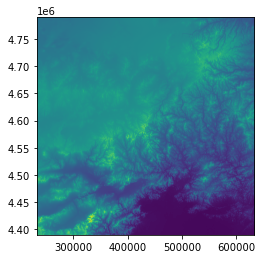

In [11]:
show(elevation, transform=transform)
plt.show()

## Calculate and Reclassify Slope

converting elevation numpy array into an rd array

In [12]:
elevation_rd = rd.rdarray(elevation, no_data=nodata)

transform = spatial data attached the file. for rd array, need to transform to gdal

In [13]:
elevation_rd.geotransform = transform.to_gdal()

In [14]:
slope = rd.TerrainAttribute(elevation_rd, attrib='slope_percentage')

In [15]:
slope

rdarray([[ 0.43920523,  1.1785113 ,  2.2222223 , ...,  0.7081972 ,
           0.7081972 ,  0.58925563],
         [ 2.6425414 ,  2.7916322 ,  1.3176157 , ...,  0.2777778 ,
           1.1453071 ,  1.4163944 ],
         [ 2.160604  ,  1.767767  ,  1.1453071 , ...,  0.58925563,
           0.5555556 ,  1.1453071 ],
         ...,
         [ 3.0681558 , 13.455746  , 20.90912   , ...,  0.7081972 ,
           0.7081972 ,  1.2576923 ],
         [10.441637  , 14.021588  ,  3.5409858 , ...,  0.2777778 ,
           1.001542  ,  0.98209274],
         [15.940186  , 15.718393  ,  6.809806  , ...,  0.2777778 ,
           0.8333333 ,  0.43920523]], dtype=float32)

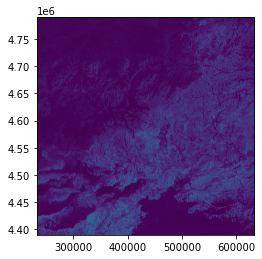

In [16]:
show(slope, transform=transform)
plt.show()

In [18]:
slope_reclass = np.full(shape, np.NaN)

In [20]:
slope_reclass[slope <= 2] = 5
slope_reclass[(slope > 2) & (slope <= 4)] = 4
slope_reclass[(slope > 4) & (slope <= 6)] = 3
slope_reclass[(slope > 6) & (slope <= 8)] = 2
slope_reclass[slope > 8] = 1

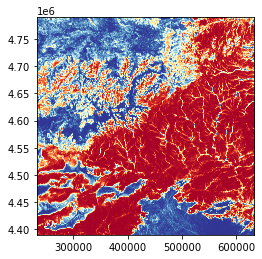

In [21]:
show(slope_reclass, transform=transform, cmap='RdYlBu')
plt.show()

## Create a Wind Preference Grid

In [22]:
wind = gpd.read_file('./data/wind/wind.shp')

In [23]:
wind.head()

,ID,GRIDCODE,geometry
0,37603,3,"POLYGON ((295648.833 4790893.526, 298648.097 4..."
1,37659,2,"POLYGON ((254698.979 4788713.657, 253699.218 4..."
2,37660,3,"POLYGON ((263696.430 4788854.299, 263674.897 4..."
3,37661,2,"POLYGON ((305646.143 4790893.526, 306645.837 4..."
4,37700,2,"POLYGON ((243722.531 4787541.562, 242722.665 4..."


plotting above data 

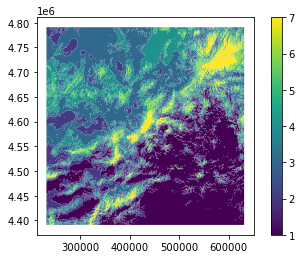

In [24]:
wind.plot(column='GRIDCODE', legend=True)
plt.show()

select all the polygons that have a gridcode higher than 3

In [25]:
high_wind = wind[wind['GRIDCODE'] >= 3]

In [26]:
high_wind.head()

,ID,GRIDCODE,geometry
0,37603,3,"POLYGON ((295648.833 4790893.526, 298648.097 4..."
2,37660,3,"POLYGON ((263696.430 4788854.299, 263674.897 4..."
5,37741,3,"POLYGON ((238723.110 4787465.243, 238744.490 4..."
7,37793,4,"POLYGON ((380675.000 4787826.912, 379676.095 4..."
8,37794,3,"POLYGON ((514495.056 4790437.615, 514484.562 4..."


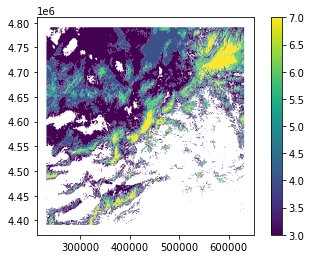

In [27]:
high_wind.plot(column='GRIDCODE', legend=True)
plt.show()

In [ ]:
calculating a distance matrix to these polygons

using features module from rasterio to create binary. everywhere there is a polygon, put zero. not polygon, put 1 (0=high wind area, 1=no high wind area).

In [28]:
wind_raster = features.rasterize(high_wind['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

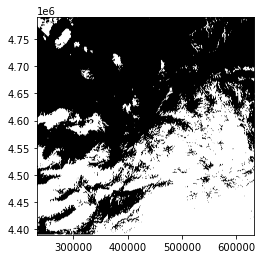

In [29]:
show(wind_raster, transform=transform, cmap='gray')
plt.show()

In [30]:
wind_distance = ndimage.distance_transform_edt(wind_raster) * res[0]

In [31]:
wind_distance

array([[ 6160.23538511,  6078.83212468,  5997.67454936, ...,
          540.        ,   630.        ,   720.        ],
       [ 6122.64648661,  6040.73671004,  5959.06032861, ...,
          540.        ,   630.        ,   720.        ],
       [ 6086.15642257,  6003.74882886,  5921.56229385, ...,
          540.        ,   630.        ,   720.        ],
       ...,
       [  810.        ,   810.        ,   810.        , ...,
        30399.35690109, 30423.99382067, 30448.87682658],
       [  900.        ,   900.        ,   900.        , ...,
        30485.96398345, 30510.53096883, 30535.34345639],
       [  990.        ,   990.        ,   990.        , ...,
        30572.5906655 , 30597.08809675, 30621.83044823]])

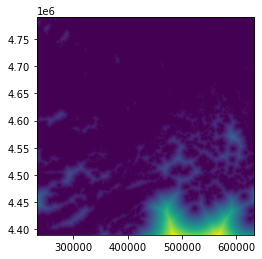

In [32]:
show(wind_distance, transform=transform)
plt.show()

In [33]:
wind_reclass = np.full(shape, np.NaN)
wind_reclass[wind_distance <= 2000] = 5
wind_reclass[(wind_distance > 2000) & (wind_distance <= 4000)] = 4
wind_reclass[(wind_distance > 4000) & (wind_distance <= 6000)] = 3
wind_reclass[(wind_distance > 6000) & (wind_distance <= 8000)] = 2
wind_reclass[wind_distance > 8000] = 1

In [34]:
wind_reclass

array([[2., 2., 3., ..., 5., 5., 5.],
       [2., 2., 3., ..., 5., 5., 5.],
       [2., 2., 3., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 1., 1., 1.],
       [5., 5., 5., ..., 1., 1., 1.],
       [5., 5., 5., ..., 1., 1., 1.]])

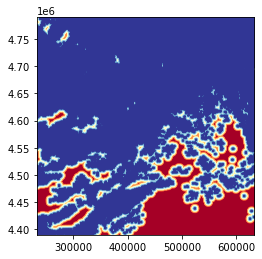

In [35]:
show(wind_reclass, transform=transform, cmap='RdYlBu')
plt.show()

## Consider Distance to the Great Wall

In [36]:
wall = gpd.read_file('./data/greatwall/greatwall.shp')

In [37]:
wall.head()

,Name,geometry
0,Wall,"LINESTRING (288667.963 4624197.541, 290850.977..."
1,Wall,"LINESTRING (301161.189 4623607.821, 302199.173..."
2,Wall,"LINESTRING (313466.890 4625294.736, 315434.012..."
3,Wall,"LINESTRING (409382.900 4657709.280, 412111.879..."
4,Wall,"LINESTRING (515956.813 4671799.826, 515134.076..."


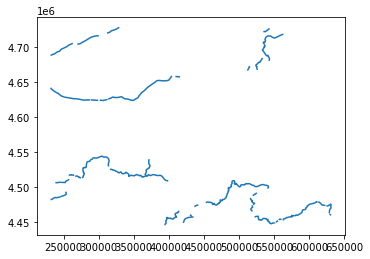

In [38]:
wall.plot()
plt.show()

In [39]:
wall_raster = features.rasterize(wall['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

In [40]:
wall_raster

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

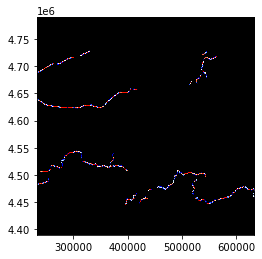

In [41]:
show(wall_raster, transform=transform, cmap='flag')
plt.show()

In [42]:
wall_distance = ndimage.distance_transform_edt(wall_raster) * res[0]

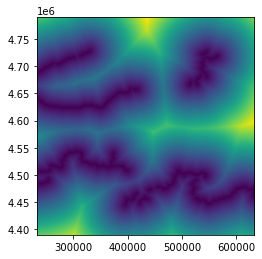

In [43]:
show(wall_distance, transform=transform)
plt.show()

In [44]:
wall_reclass = np.full(shape, np.NaN)
wall_reclass[wall_distance <= 2000] = 1
wall_reclass[(wall_distance <= 5000) & (wall_distance > 2000)] = 2
wall_reclass[(wall_distance <= 8000) & (wall_distance > 5000)] = 3
wall_reclass[(wall_distance <= 10000) & (wall_distance > 8000)] = 4
wall_reclass[wall_distance > 10000] = 5

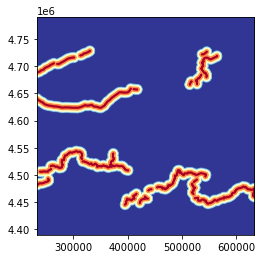

In [45]:
show(wall_reclass, transform=transform, cmap='RdYlBu')
plt.show()

## Consider Distance to Power Lines

In [46]:
powerlines = gpd.read_file('./data/powerlines/powerlines.shp')

In [47]:
powerlines.head()

,Name,geometry
0,Power Transmission Line,"LINESTRING (444002.650 4391103.746, 444455.911..."
1,Power Transmission Line,"LINESTRING (449993.495 4406912.790, 448730.430..."
2,Power Transmission Line,"LINESTRING (425006.352 4411223.570, 425003.657..."
3,Power Transmission Line,"LINESTRING (608431.815 4401241.956, 607729.428..."
4,Power Transmission Line,"LINESTRING (609677.383 4402372.566, 609179.424..."


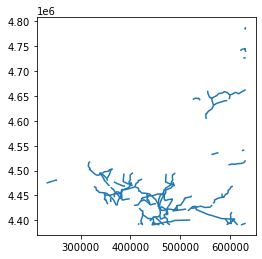

In [48]:
powerlines.plot()
plt.show()

In [49]:
powerlines_raster = features.rasterize(powerlines['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

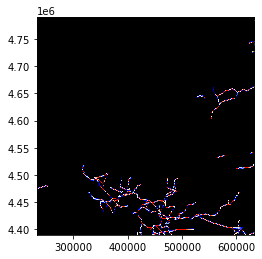

In [50]:
show(powerlines_raster, transform=transform, cmap='flag')
plt.show()

In [51]:
powerlines_distance = ndimage.distance_transform_edt(powerlines_raster) * res[0]

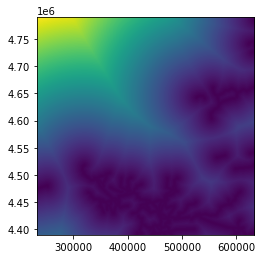

In [52]:
show(powerlines_distance, transform=transform)
plt.show()

In [53]:
powerlines_reclass = np.full(shape, np.NaN)
powerlines_reclass[powerlines_distance <= 1000] = 5
powerlines_reclass[(powerlines_distance > 1000) & (powerlines_distance <= 3000)] = 4
powerlines_reclass[(powerlines_distance > 3000) & (powerlines_distance <= 5000)] = 3
powerlines_reclass[(powerlines_distance > 5000) & (powerlines_distance <= 8000)] = 2
powerlines_reclass[powerlines_distance > 8000] = 1

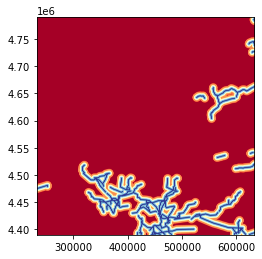

In [54]:
show(powerlines_reclass, transform=transform, cmap='RdYlBu')
plt.show()

## Calculate Suitablity Grid

In [55]:
suitability = slope_reclass + wind_reclass + wall_reclass + powerlines_reclass

In [56]:
suitability

array([[13., 13., 13., ..., 19., 19., 19.],
       [12., 12., 14., ..., 19., 19., 19.],
       [12., 13., 14., ..., 19., 19., 19.],
       ...,
       [15., 12., 12., ..., 14., 14., 14.],
       [12., 12., 15., ..., 14., 14., 14.],
       [12., 12., 13., ..., 14., 14., 14.]])

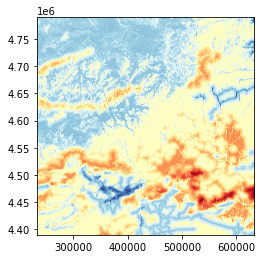

In [57]:
show(suitability, transform=transform, cmap='RdYlBu')
plt.show()

In [58]:
weighted_suitability = slope_reclass * 0.125 + wind_reclass * 0.5 + wall_reclass * 0.125 + powerlines_reclass * 0.25

In [59]:
weighted_suitability

array([[2.5  , 2.5  , 2.875, ..., 4.75 , 4.75 , 4.75 ],
       [2.375, 2.375, 3.   , ..., 4.75 , 4.75 , 4.75 ],
       [2.375, 2.5  , 3.   , ..., 4.75 , 4.75 , 4.75 ],
       ...,
       [3.875, 3.5  , 3.5  , ..., 2.5  , 2.5  , 2.5  ],
       [3.5  , 3.5  , 3.875, ..., 2.5  , 2.5  , 2.5  ],
       [3.5  , 3.5  , 3.625, ..., 2.5  , 2.5  , 2.5  ]])

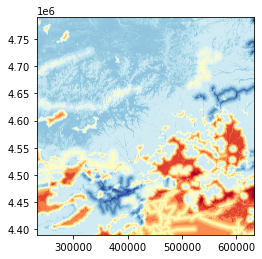

In [60]:
show(weighted_suitability, transform=transform, cmap='RdYlBu')
plt.show()

## Perform Zonal Statistics

In [61]:
counties = gpd.read_file('./data/counties/counties.shp')

In [62]:
counties.head()

,OBJECTID,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,CCN_3,CCA_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,Shape_Leng,Shape_Area,geometry
0,78,49,CHN,China,2,Beijing,18,Beijing,78,Beijing,0,None,Zhíxiáshì,Municipality,北京|北京,Běijīng,2.055747,0.143487,"POLYGON ((465226.098 4431092.251, 465764.909 4..."
1,79,49,CHN,China,2,Beijing,18,Beijing,79,Changping,0,None,Shìxiáqū,District,昌平区,Chāngpíng,1.836572,0.142352,"POLYGON ((456655.030 4456034.734, 456814.270 4..."
2,80,49,CHN,China,2,Beijing,18,Beijing,80,Daxing,0,None,Shìxiáqū,District,大兴区,Dàxīng,1.902640,0.106558,"POLYGON ((434478.732 4374532.482, 434436.832 4..."
3,81,49,CHN,China,2,Beijing,18,Beijing,81,Fangshan,0,None,Shìxiáqū,District,房山区,Fángshān,2.378266,0.214635,"POLYGON ((376985.588 4407936.952, 377347.072 4..."
4,82,49,CHN,China,2,Beijing,18,Beijing,82,Huairou,0,None,Shìxiáqū,District,怀柔区,Huáiróu,3.369653,0.226143,"POLYGON ((490094.200 4516212.327, 489568.167 4..."


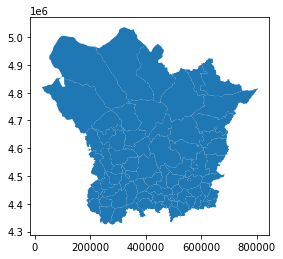

In [63]:
counties.plot()
plt.show()

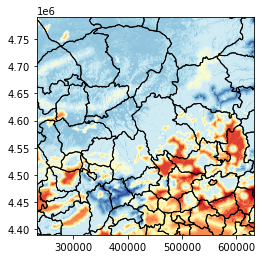

In [64]:
ax = counties.plot(facecolor='None', edgecolor='black')
show(weighted_suitability, cmap='RdYlBu', ax=ax, transform=transform)
plt.show()

In [67]:
bounds

BoundingBox(left=232106.3019110937, bottom=4389873.692702995, right=632336.3019110938, top=4790103.692702995)

In [68]:
extent = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

In [69]:
counties_select = counties[counties.within(extent)].reset_index(drop=True)

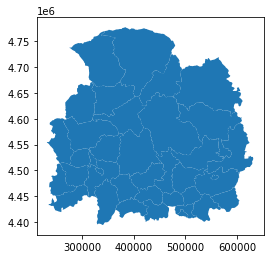

In [70]:
counties_select.plot()
plt.show()

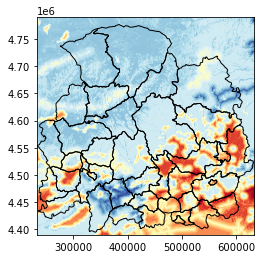

In [71]:
ax = counties_select.plot(facecolor='None', edgecolor='black')
show(weighted_suitability, cmap='RdYlBu', ax=ax, transform=transform)
plt.show()

In [74]:
zonal_stats(counties_select, weighted_suitability, affine=transform, stats=['mean', 'count'], nodata = np.NaN)

[{'mean': 2.7136650057744283, 'count': 167982},
 {'mean': 3.048941197376109, 'count': 166013},
 {'mean': 2.542385597472518, 'count': 262079},
 {'mean': 3.71870872759498, 'count': 174905},
 {'mean': 2.430913989385407, 'count': 271513},
 {'mean': 2.7397877141199753, 'count': 117224},
 {'mean': 2.489752082376861, 'count': 121976},
 {'mean': 3.47936788695951, 'count': 247345},
 {'mean': 2.542189427384276, 'count': 61612},
 {'mean': 2.6447321224526297, 'count': 503215},
 {'mean': 3.3332393782527365, 'count': 1079860},
 {'mean': 3.1449235413673216, 'count': 671605},
 {'mean': 2.639762792483524, 'count': 395877},
 {'mean': 3.6420066333339975, 'count': 1104422},
 {'mean': 2.900684243118865, 'count': 400479},
 {'mean': 2.2938091016548463, 'count': 11844},
 {'mean': 2.473309279873904, 'count': 20302},
 {'mean': 2.48490775029758, 'count': 75610},
 {'mean': 1.968163683567159, 'count': 178338},
 {'mean': 3.4002090039083845, 'count': 649629},
 {'mean': 3.365141699918273, 'count': 291214},
 {'mean': 

In [76]:
stats = pd.DataFrame(zonal_stats(counties_select, weighted_suitability, affine=transform, stats=['mean', 'count'], nodata = np.NaN))

In [77]:
stats.head()

,mean,count
0,2.713665,167982
1,3.048941,166013
2,2.542386,262079
3,3.718709,174905
4,2.430914,271513


In [78]:
counties_stats = counties_select.join(stats)

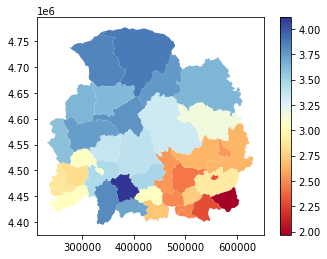

In [79]:
counties_stats.plot(column = 'mean', cmap='RdYlBu', legend=True)
plt.show()